<a href="https://colab.research.google.com/github/silviolima07/Gol/blob/main/Gol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'>Processo Seletivo Gol</font>


In [112]:
import sklearn as sk
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.pylabtools import figsize
from IPython.display import display, HTML
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200) 
pd.set_option('display.max_rows', 200)
pd.set_option('precision', 2)
from imblearn.over_sampling import SMOTE
import datetime
import gc
import seaborn as sns

from fbprophet import Prophet

from scipy import stats
import numpy as np

# Importa pacotes do sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extraindo e Carregando os Dados

In [3]:
# Função que identifica linhas com dados ausentes
# Retorna as linhas e percentuais em cada coluna
#
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) + " columns that have missing values.")
        return mz_table

In [4]:
# Função que remove dados considerados outliers
# Acima dos limites superiores e inferiores
#
def remove_outlier(df, col):  
    _std = round(df[col].std(), 5)
    _mean= round(df[col].mean(), 5)    
    _min = round(_mean - df[col].std()*3, 5)
    _max = round(_mean + df[col].std()*3, 5)
  
    df.loc[(df[col] < _min) | (df[col] > _max)] = _mean
    df[col] = round(df[col], 5)

## Análise Exploratória de Dados

In [5]:
# Carregando arquivo csv
gol= '/content/drive/MyDrive/Colab Notebooks/Dataset/Gol/case_analytics-ds.csv'


df = pd.read_csv(gol, encoding="latin")

### Estatística Descritiva

In [6]:
df.shape

(2432, 6)

In [7]:
# Visualizando as primeiras linhas
df.head()

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK
0,11/1/2016,Telégrafo,Mindscape,30,"R$ 2,188.11",3476
1,11/1/2016,TeleVenda,Arena,52,"R$ 3,302.38",8197
2,11/1/2016,TeleVenda,Mindscape,19,"R$ 1,041.54",2425
3,11/1/2016,Porta a Porta,Mindscape,496,"R$ 15,566.34",53278
4,11/1/2016,TeleVenda,Vast,46,"R$ 2,721.43",2039


In [8]:
missing_zero_values_table(df)

Your selected dataframe has 6 columns and 2432 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [9]:
df.isnull().sum()

Data Venda           0
Canal de Venda       0
Local de Venda       0
PAX                  0
Monetário Vendido    0
RPK                  0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Data Venda         2432 non-null   object
 1   Canal de Venda     2432 non-null   object
 2   Local de Venda     2432 non-null   object
 3   PAX                2432 non-null   int64 
 4   Monetário Vendido  2432 non-null   object
 5   RPK                2432 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 114.1+ KB


In [11]:
temp = df['Monetário Vendido'].str.replace('R\$', '')
temp = temp.str.replace(',', '')
df['Monetário Vendido'] = temp
df['Monetário Vendido'] = df['Monetário Vendido'].astype('float64')


In [12]:
df['Data Venda'] = pd.to_datetime(df['Data Venda'], format='%m/%d/%Y')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Data Venda         2432 non-null   datetime64[ns]
 1   Canal de Venda     2432 non-null   object        
 2   Local de Venda     2432 non-null   object        
 3   PAX                2432 non-null   int64         
 4   Monetário Vendido  2432 non-null   float64       
 5   RPK                2432 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 114.1+ KB


In [14]:
df['Ano'] = df['Data Venda'].dt.year
#
df['Mês'] = df['Data Venda'].dt.month
#
df['Dia_do_Mês'] = df['Data Venda'].dt.day
#
df['Dia_da_Semana'] = df['Data Venda'].dt.day_name()
df['Dia_da_Semana_Numero'] = df['Data Venda'].dt.dayofweek
df['Nome_do_Dia'] = df['Dia_da_Semana']
df["Nome_do_Dia"].replace({"Sunday": "Domingo", "Monday": "Segunda",
                             "Tuesday": "Terça", "Wednesday": "Quarta",
                             "Thursday": "Quinta", 'Friday': "Sexta",
                             'Saturday': "Sabado"}, inplace=True)
del df['Dia_da_Semana']

In [15]:
df

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça
1,2016-11-01,TeleVenda,Arena,52,3302.38,8197,2016,11,1,1,Terça
2,2016-11-01,TeleVenda,Mindscape,19,1041.54,2425,2016,11,1,1,Terça
3,2016-11-01,Porta a Porta,Mindscape,496,15566.34,53278,2016,11,1,1,Terça
4,2016-11-01,TeleVenda,Vast,46,2721.43,2039,2016,11,1,1,Terça
...,...,...,...,...,...,...,...,...,...,...,...
2427,2017-04-01,Porta a Porta,Vast,1079,28486.40,54551,2017,4,1,5,Sabado
2428,2017-04-01,Porta a Porta,Ellipsis,841,23601.00,46988,2017,4,1,5,Sabado
2429,2017-04-01,TeleVenda,Arena,175,10270.29,26599,2017,4,1,5,Sabado
2430,2017-04-01,Telégrafo,Arena,105,5470.41,15130,2017,4,1,5,Sabado


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Data Venda            2432 non-null   datetime64[ns]
 1   Canal de Venda        2432 non-null   object        
 2   Local de Venda        2432 non-null   object        
 3   PAX                   2432 non-null   int64         
 4   Monetário Vendido     2432 non-null   float64       
 5   RPK                   2432 non-null   int64         
 6   Ano                   2432 non-null   int64         
 7   Mês                   2432 non-null   int64         
 8   Dia_do_Mês            2432 non-null   int64         
 9   Dia_da_Semana_Numero  2432 non-null   int64         
 10  Nome_do_Dia           2432 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 209.1+ KB


In [17]:
# Apenas dos valores numéricos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,2432.0,723.00,735.94,18.00,100.00,395.50,1160.25,4705.00
Monetário Vendido,2432.0,24638.74,22424.84,1041.54,6122.92,17755.42,35535.33,144890.73
RPK,2432.0,66738.39,83479.04,1127.00,11372.00,33361.50,95116.75,695824.00
Ano,2432.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,2432.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,2432.0,15.53,8.80,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,2432.0,3.00,1.98,0.00,1.00,3.00,5.00,6.00


In [18]:
df['RPK'].median()

33361.5

In [19]:
# Contagem por tipo de Canal de Venda
df['Canal de Venda'].value_counts()


TeleVenda        1216
Porta a Porta     608
Telégrafo         608
Name: Canal de Venda, dtype: int64

In [20]:
# Contagem por tipo de Local de Venda
df['Local de Venda'].value_counts()

Ellipsis     608
Vast         608
Mindscape    608
Arena        608
Name: Local de Venda, dtype: int64

In [21]:
# Contagem por Ano
df['Ano'].value_counts()

2017    1456
2016     976
Name: Ano, dtype: int64

In [22]:
# Contagem por Mês
df['Mês'].value_counts()

3     496
1     496
12    496
11    480
2     448
4      16
Name: Mês, dtype: int64

In [23]:
# Contagem por Dia
df['Nome_do_Dia'].value_counts()

Terça      352
Quinta     352
Sexta      352
Sabado     352
Quarta     352
Segunda    336
Domingo    336
Name: Nome_do_Dia, dtype: int64

In [24]:
df.head()

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça
1,2016-11-01,TeleVenda,Arena,52,3302.38,8197,2016,11,1,1,Terça
2,2016-11-01,TeleVenda,Mindscape,19,1041.54,2425,2016,11,1,1,Terça
3,2016-11-01,Porta a Porta,Mindscape,496,15566.34,53278,2016,11,1,1,Terça
4,2016-11-01,TeleVenda,Vast,46,2721.43,2039,2016,11,1,1,Terça


#### Agrupando por Ano

In [25]:
df[['Monetário Vendido', 'Ano']].groupby(by =["Ano"]).sum()

,Monetário Vendido
Ano,
2016,2.33e+07
2017,3.66e+07


#### Agrupando por Mês


In [26]:
df[['Monetário Vendido', 'Mês']].groupby(by =["Mês"]).sum()

,Monetário Vendido
Mês,
1,1.26e+07
2,1.12e+07
3,1.24e+07
4,4.35e+05
11,1.21e+07
12,1.12e+07


#### Agrupando por Canal de Venda

In [27]:
df[['Monetário Vendido', 'Canal de Venda']].groupby(by =["Canal de Venda"]).sum()

,Monetário Vendido
Canal de Venda,
Porta a Porta,1.91e+07
TeleVenda,3.80e+07
Telégrafo,2.79e+06


#### Agrupando por Local de Venda

In [28]:
df[['Monetário Vendido', 'Local de Venda']].groupby(by =["Local de Venda"]).sum()

,Monetário Vendido
Local de Venda,
Arena,1.92e+07
Ellipsis,1.12e+07
Mindscape,1.47e+07
Vast,1.48e+07


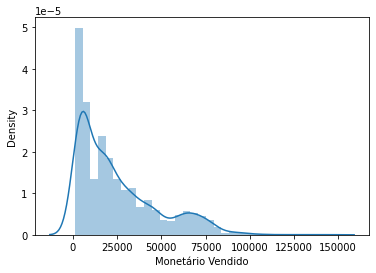

In [29]:
# Distribuição dos dados - histograma
sns.distplot(df['Monetário Vendido']);









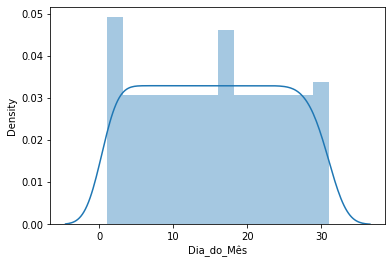

In [32]:
# Distribuição dos dados - histograma
sns.distplot(df['Dia_do_Mês']);

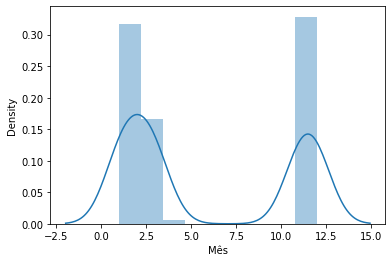

In [33]:
# Distribuição dos dados - histograma
sns.distplot(df['Mês'])

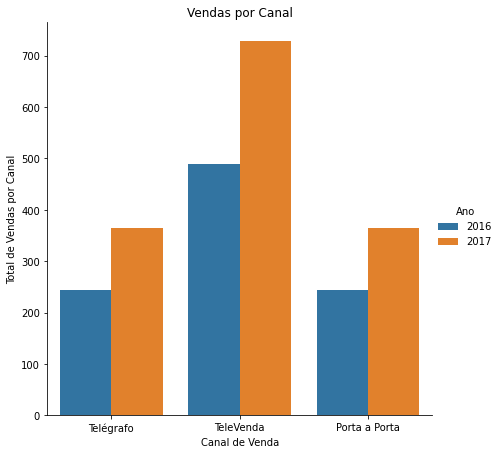

In [34]:
# Total Vendas por Canal
mx = sns.catplot(x = "Canal de Venda", hue = 'Ano', data = df, kind = "count", height = 6)
mx.set(ylabel = 'Total de Vendas por Canal')
plt.title('Vendas por Canal');

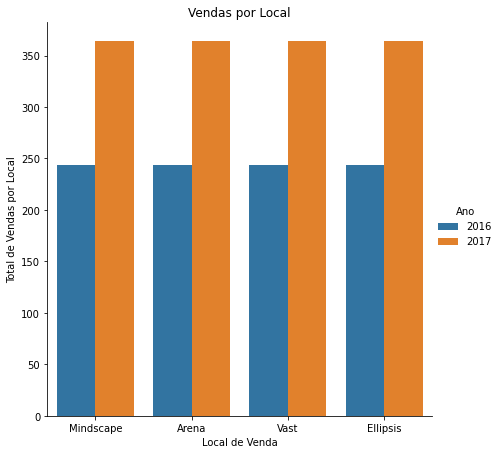

In [35]:
# Total Vendas por Local de Venda
mx = sns.catplot(x = "Local de Venda", hue = 'Ano', data = df, kind = "count", height = 6)
mx.set(ylabel = 'Total de Vendas por Local')
plt.title('Vendas por Local');

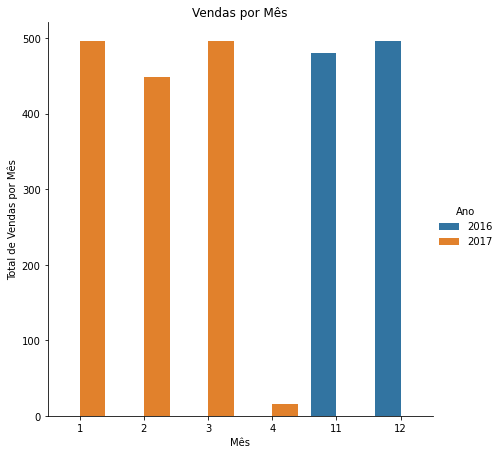

In [36]:
# Total Vendas por Mês
mx = sns.catplot(x = "Mês", hue = 'Ano', data = df, kind = "count", height = 6)
mx.set(ylabel = 'Total de Vendas por Mês')
plt.title('Vendas por Mês');

## Questões
###1-Faça um ranking para o número total de PAX por dia da semana.																	
###2-Qual a correlação de sábado e domingo somados com o total de RPK?																	
###3-Qual a média de ‘Monetário’ por mês por Canal? E a mediana?																	
###4-Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre) 																	
###5-Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?																	
###6-Criar modelo relacionando o comporatamento de venda com variaveis não apresentada nos dados (Ex : PIB, Dolar, e etc)			

In [ ]:



																	
																
4-Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre) 																	
5-Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?																	
6-Criar modelo relacionando o comporatamento de venda com variaveis não apresentada nos dados (Ex : PIB, Dolar, e etc)			

### 1 - Faça um ranking para o número total de PAX por dia da semana.

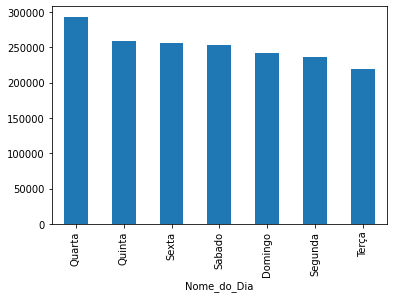

In [41]:
ranking_Dia_PAX = df.groupby(['Nome_do_Dia'])['PAX'].sum().sort_values(ascending=False)
ranking_Dia_PAX.plot(x='Nome_do_Dia', y="PAX", kind= 'bar')

### 2 - Qual a correlação de sábado e domingo somados com o total de RPK?

In [38]:
df_sabado_domingo = df.loc[(df['Nome_do_Dia'] == 'Sabado') | (df['Nome_do_Dia'] == 'Domingo')]

In [39]:
df_sabado_domingo

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
64,2016-11-05,TeleVenda,Mindscape,1378,60813.49,164710,2016,11,5,5,Sabado
65,2016-11-05,Telégrafo,Ellipsis,42,2695.44,2399,2016,11,5,5,Sabado
66,2016-11-05,TeleVenda,Arena,206,15726.53,32153,2016,11,5,5,Sabado
67,2016-11-05,Porta a Porta,Vast,1314,30005.76,61962,2016,11,5,5,Sabado
68,2016-11-05,Porta a Porta,Mindscape,877,34594.72,98153,2016,11,5,5,Sabado
...,...,...,...,...,...,...,...,...,...,...,...
2427,2017-04-01,Porta a Porta,Vast,1079,28486.40,54551,2017,4,1,5,Sabado
2428,2017-04-01,Porta a Porta,Ellipsis,841,23601.00,46988,2017,4,1,5,Sabado
2429,2017-04-01,TeleVenda,Arena,175,10270.29,26599,2017,4,1,5,Sabado
2430,2017-04-01,Telégrafo,Arena,105,5470.41,15130,2017,4,1,5,Sabado


In [42]:
df[['Dia_da_Semana_Numero', 'RPK']].corr()

,Dia_da_Semana_Numero,RPK
Dia_da_Semana_Numero,1.00e+00,1.34e-04
RPK,1.34e-04,1.00e+00


### 3 - Qual a média de ‘Monetário’ por mês por Canal? E a mediana?	

In [43]:
temp = df.copy()
temp = temp.rename(columns={"Monetário Vendido": "Monetário"})

In [44]:
# Media de Monetário por Mês e Canal de Venda
monet_mean = temp[['Monetário', 'Mês', "Canal de Venda"]].groupby(by =['Mês', "Canal de Venda"]).mean()
#
# Mediana de Monetário por Mês e Canal de Venda
monet_mead = temp[['Monetário', 'Mês', "Canal de Venda"]].groupby(by =['Mês', "Canal de Venda"]).median()

In [45]:
print("Valor da Mediana de Monetário por Mês e Canal de Venda\n\n", monet_mead)

Valor da Mediana de Monetário por Mês e Canal de Venda

                     Monetário
Mês Canal de Venda           
1   Porta a Porta    28823.03
    TeleVenda        19085.12
    Telégrafo         3782.25
2   Porta a Porta    29711.58
    TeleVenda        18926.69
    Telégrafo         4045.89
3   Porta a Porta    30488.19
    TeleVenda        18666.88
    Telégrafo         4345.56
4   Porta a Porta    32421.61
    TeleVenda        28091.89
    Telégrafo         3458.89
11  Porta a Porta    30262.98
    TeleVenda        18757.71
    Telégrafo         4029.14
12  Porta a Porta    25527.52
    TeleVenda        17567.60
    Telégrafo         4227.57


In [46]:
print("Valor da Medio de Monetário por Mês e Canal de Venda\n\n", monet_mean)

Valor da Medio de Monetário por Mês e Canal de Venda

                     Monetário
Mês Canal de Venda           
1   Porta a Porta    31320.57
    TeleVenda        32868.88
    Telégrafo         4234.02
2   Porta a Porta    31710.15
    TeleVenda        32208.45
    Telégrafo         4307.63
3   Porta a Porta    31055.94
    TeleVenda        32132.25
    Telégrafo         4568.15
4   Porta a Porta    33319.50
    TeleVenda        35795.78
    Telégrafo         3778.59
11  Porta a Porta    34638.07
    TeleVenda        30963.46
    Telégrafo         4614.31
12  Porta a Porta    28615.45
    TeleVenda        28045.72
    Telégrafo         5212.65


### 4 - Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre)

In [47]:
df.head()

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça
1,2016-11-01,TeleVenda,Arena,52,3302.38,8197,2016,11,1,1,Terça
2,2016-11-01,TeleVenda,Mindscape,19,1041.54,2425,2016,11,1,1,Terça
3,2016-11-01,Porta a Porta,Mindscape,496,15566.34,53278,2016,11,1,1,Terça
4,2016-11-01,TeleVenda,Vast,46,2721.43,2039,2016,11,1,1,Terça


In [48]:
df['Local de Venda'].value_counts()

Ellipsis     608
Vast         608
Mindscape    608
Arena        608
Name: Local de Venda, dtype: int64

#### Separando os conjuntos de dados de cada Local de Venda

In [162]:
temp = df.copy()
temp_Mindscape = df.loc[temp['Local de Venda']== "Mindscape"]
#
temp_Arena = df.loc[temp['Local de Venda']== "Arena"]
#
temp_Vast = df.loc[temp['Local de Venda']== "Vast"]
#
temp_Ellipsis = df.loc[temp['Local de Venda']== "Ellipsis"]

#### Forecast dos próximos 15 dias de PAX por Local de Venda, 
#### a partir do última dia de venda.

In [51]:
# Forecast by Prophet
prediction_size = 15 # dias

In [52]:
# A função recebe o local de venda e o conjunto de dados naquele local
# A ultima data de venda no local é extraida selecionado o maior valor no campo Data Venda
# A previsão é definida para um intervalo de confiança~de 95%
# Após o modelo fazer a previsão, é feita filtragem dos 15 dias previstos
# É feito um gráfico que apresenta a evolução do valor de PAX no periodo.
#
# retorna o dataset com as previsões de 15 dias
#
def predict_pax(local,df):
  model = Prophet(interval_width=0.95)
  df = df.rename(columns={"Data Venda": "ds", "PAX": "y"})
  model.fit(df)
  future = model.make_future_dataframe(periods=prediction_size)
  forecast = model.predict(future)
  ultima_venda = df['ds'].max()
  forecast_next_15_days = forecast.loc[forecast.ds > ultima_venda ]
  fig = model.plot(forecast_next_15_days, figsize=(10,5))
  ax = fig.gca()
  ax.set_title(local+"\nForecast by Prophet\nPeriodo: 15 dias a partir da última registrada", size=18)
  ax.set_xlabel("Date", size=14)
  ax.set_ylabel("PAX", size=14)
  ax.tick_params(axis='x', labelsize=10)
  ax.tick_params(axis='y', labelsize=10)
  #
  #fig = model.plot_components(forecast, figsize=(10,5))
  return forecast_next_15_days

In [53]:
# A função recebe o local e as previsões, faz ajustes nos nomes das colunas
# E apresentas previsões efetuadas pela lib Prophet
def resultado(local, forecast):
  forecast= forecast.rename(columns={"ds": "Data Venda", "yhat": "PAX"})
  print("\n",local)
  print("\nValores previstos pros próximos 15 dias")
  print("Inicio:",forecast['Data Venda'].min())
  print("Final :", forecast['Data Venda'].max())
  print("\n",forecast[['Data Venda', 'PAX']])

#### Efetuando as previsões para cada local

### Mindscape

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Mindcaspe

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda     PAX
152 2017-04-02  655.47
153 2017-04-03  678.82
154 2017-04-04  595.40
155 2017-04-05  778.86
156 2017-04-06  684.70
157 2017-04-07  678.15
158 2017-04-08  673.19
159 2017-04-09  657.35
160 2017-04-10  680.70
161 2017-04-11  597.28
162 2017-04-12  780.74
163 2017-04-13  686.58
164 2017-04-14  680.03
165 2017-04-15  675.07
166 2017-04-16  659.24


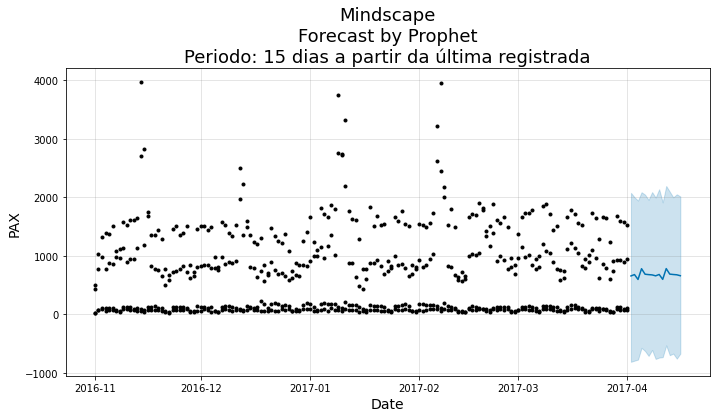

In [56]:
forecast_mindscape = predict_pax('Mindscape',temp_Mindscape);
resultado('Mindcaspe',forecast_mindscape)


### Arena

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Arena

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda     PAX
152 2017-04-02  793.23
153 2017-04-03  885.65
154 2017-04-04  682.59
155 2017-04-05  835.99
156 2017-04-06  770.91
157 2017-04-07  767.12
158 2017-04-08  769.12
159 2017-04-09  793.85
160 2017-04-10  886.28
161 2017-04-11  683.22
162 2017-04-12  836.62
163 2017-04-13  771.53
164 2017-04-14  767.75
165 2017-04-15  769.75
166 2017-04-16  794.48


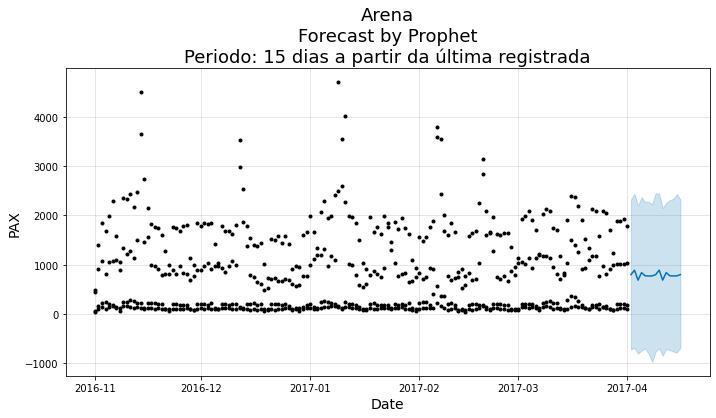

In [64]:
forecast_arena = predict_pax('Arena',temp_Arena);
resultado('Arena',forecast_arena)

### Vast


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Vast

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda      PAX
152 2017-04-02   884.68
153 2017-04-03   763.77
154 2017-04-04   754.40
155 2017-04-05  1051.70
156 2017-04-06   921.21
157 2017-04-07   902.84
158 2017-04-08   890.92
159 2017-04-09   888.32
160 2017-04-10   767.40
161 2017-04-11   758.04
162 2017-04-12  1055.33
163 2017-04-13   924.84
164 2017-04-14   906.47
165 2017-04-15   894.55
166 2017-04-16   891.95


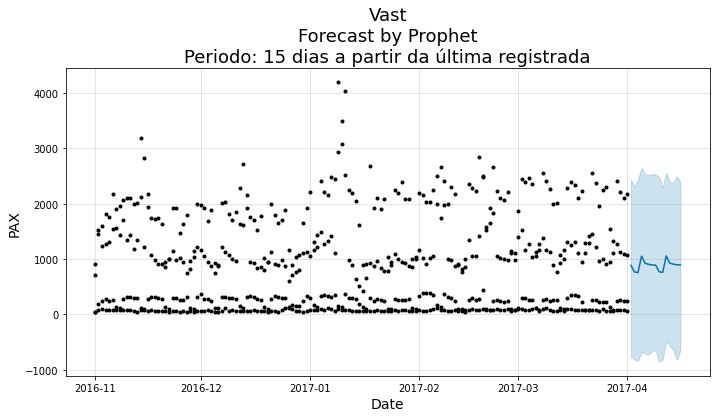

In [58]:
forecast_vast = predict_pax('Vast',temp_Vast);
resultado('Vast',forecast_vast)

### Ellipsis

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Ellipsis

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda     PAX
152 2017-04-02  656.69
153 2017-04-03  598.55
154 2017-04-04  584.79
155 2017-04-05  782.61
156 2017-04-06  679.66
157 2017-04-07  675.66
158 2017-04-08  665.83
159 2017-04-09  661.30
160 2017-04-10  603.16
161 2017-04-11  589.39
162 2017-04-12  787.22
163 2017-04-13  684.27
164 2017-04-14  680.26
165 2017-04-15  670.44
166 2017-04-16  665.91


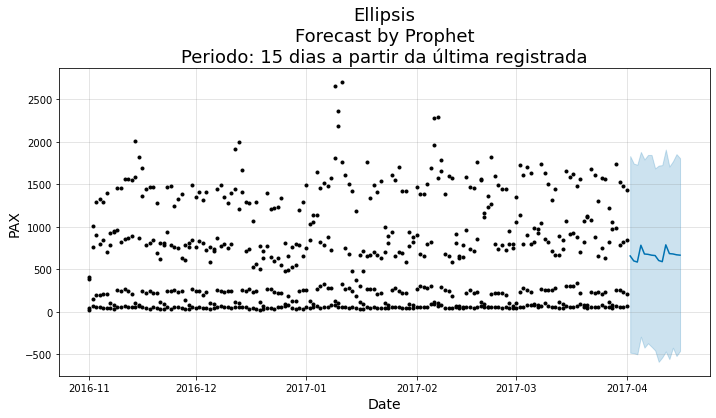

In [59]:
forecast_ellipsis = predict_pax('Ellipsis',temp_Ellipsis);
resultado('Ellipsis',forecast_ellipsis)

In [129]:
mindscape = forecast_mindscape[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_MINDSCAPE"})
arena = forecast_arena[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_ARENA"})
vast = forecast_vast[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_VAST"})
ellipsis = forecast_ellipsis[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_Ellipsis"})

In [98]:
merge1 = pd.merge(vast, arena)
#
merge2 = pd.merge(merge1, mindscape)
#
all_forecast = pd.merge(merge2, ellipsis)


### Previsões para os locais de venda

In [109]:
all_forecast

,Data Venda,PAX_VAST,PAX_ARENA,PAX_MINDSCAPE,PAX_Ellipsis
0,2017-04-02,884.68,793.23,655.47,656.69
1,2017-04-03,763.77,885.65,678.82,598.55
2,2017-04-04,754.40,682.59,595.40,584.79
3,2017-04-05,1051.70,835.99,778.86,782.61
4,2017-04-06,921.21,770.91,684.70,679.66
5,2017-04-07,902.84,767.12,678.15,675.66
6,2017-04-08,890.92,769.12,673.19,665.83
7,2017-04-09,888.32,793.85,657.35,661.30
8,2017-04-10,767.40,886.28,680.70,603.16
9,2017-04-11,758.04,683.22,597.28,589.39


### 5 - Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?

In [136]:
temp_Mindscape.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,656.78,690.23,19.00,84.50,327.50,1034.00,3961.00
Monetário Vendido,608.0,24242.94,22567.80,1041.54,5434.19,13115.23,34991.99,94836.67
RPK,608.0,78781.87,84845.12,2425.00,10556.00,35823.00,120343.75,537259.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


In [137]:
temp_Arena.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,780.24,804.76,39.00,121.00,461.00,1264.25,4705.00
Monetário Vendido,608.0,31592.25,27062.72,2249.26,7654.44,21175.89,48186.69,144890.73
RPK,608.0,113754.87,118382.80,5471.00,18211.25,62085.00,180144.50,695824.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


In [138]:
temp_Vast.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,839.90,823.41,40.00,96.00,429.00,1330.75,4191.00
Monetário Vendido,608.0,24273.38,21818.45,1497.62,5267.68,18908.01,30509.54,92007.17
RPK,608.0,39919.86,39204.33,1932.00,4551.25,20010.00,63788.25,209750.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


In [139]:
temp_Ellipsis.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,615.08,577.93,18.00,78.00,334.50,953.25,2697.00
Monetário Vendido,608.0,18446.39,14460.58,1126.69,4383.74,16457.54,25017.52,60758.26
RPK,608.0,34496.96,32220.57,1127.00,4579.00,19990.50,53505.75,152788.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


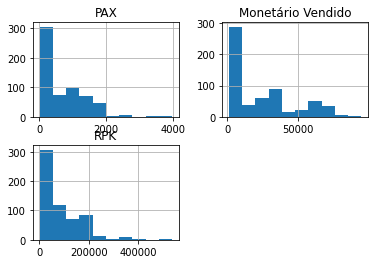

In [144]:
temp_Mindscape[['PAX', 'Monetário Vendido', 'RPK']].hist();

In [153]:
type(temp_Mindscape)

pandas.core.frame.DataFrame

In [149]:
temp_Mindscape

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça
2,2016-11-01,TeleVenda,Mindscape,19,1041.54,2425,2016,11,1,1,Terça
3,2016-11-01,Porta a Porta,Mindscape,496,15566.34,53278,2016,11,1,1,Terça
11,2016-11-01,TeleVenda,Mindscape,425,12875.54,48274,2016,11,1,1,Terça
18,2016-11-02,TeleVenda,Mindscape,1029,39705.82,122484,2016,11,2,2,Quarta
...,...,...,...,...,...,...,...,...,...,...,...
2412,2017-03-31,Telégrafo,Mindscape,78,4631.52,10472,2017,3,31,4,Sexta
2418,2017-04-01,TeleVenda,Mindscape,104,6125.41,12725,2017,4,1,5,Sabado
2423,2017-04-01,TeleVenda,Mindscape,1527,64818.93,184869,2017,4,1,5,Sabado
2424,2017-04-01,Porta a Porta,Mindscape,950,36356.82,110375,2017,4,1,5,Sabado


In [161]:
temp_Arena[['PAX', 'Monetário Vendido', 'RPK']].hist();

KeyError: ignored

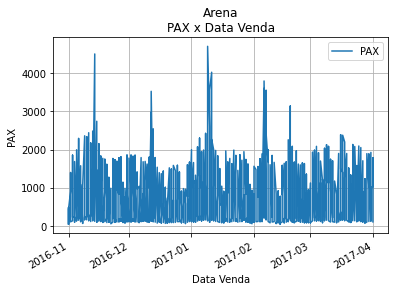

In [173]:
Arena_pax=temp_Arena[['PAX','Data Venda']]
(Arena_pax.set_index(['Data Venda'])).plot();
plt.title("Arena\nPAX x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("PAX"), plt.grid(b=True);

In [174]:
temp_Arena

,PAX,Data Venda
1,52,2016-11-01
5,485,2016-11-01
7,39,2016-11-01
15,437,2016-11-01
17,900,2016-11-02
...,...,...
2409,1006,2017-03-31
2419,1026,2017-04-01
2426,1786,2017-04-01
2429,175,2017-04-01


In [171]:
temp_Arena=temp_Arena[['Monetário Vendido','Data Venda']]
(temp_Arena.set_index(['Data Venda'])).plot();
plt.title("Arena\nMonetário Vendido x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("Monetário Vendido"), plt.grid(b=True);

KeyError: ignored

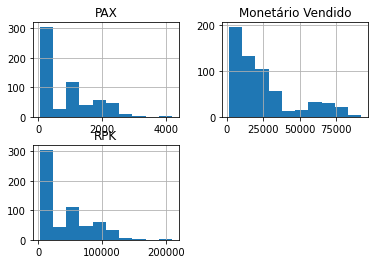

In [146]:
temp_Vast[['PAX', 'Monetário Vendido', 'RPK']].hist();

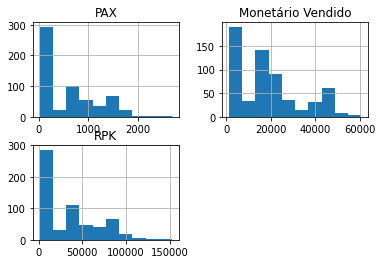

In [147]:
temp_Ellipsis[['PAX', 'Monetário Vendido', 'RPK']].hist();

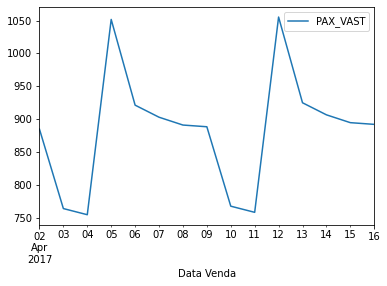

In [132]:
(vast.set_index(['Data Venda'])).plot();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ec6f7d5f8>]],
      dtype=object)

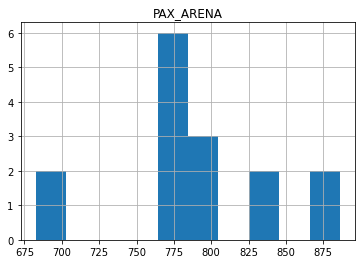

In [104]:
arena.hist()

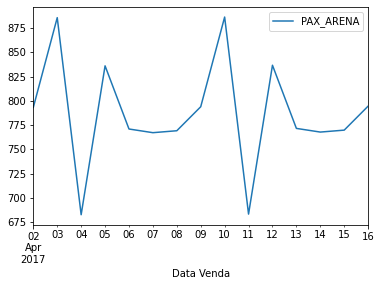

In [133]:
(arena.set_index(['Data Venda'])).plot();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ec6f61240>]],
      dtype=object)

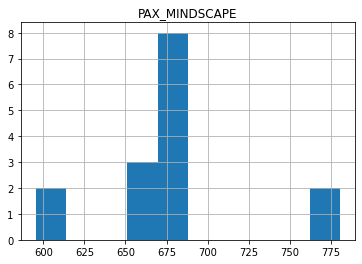

In [105]:
mindscape.hist()

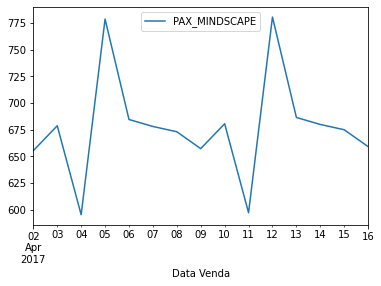

In [134]:
(mindscape.set_index(['Data Venda'])).plot();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ec6fe5d68>]],
      dtype=object)

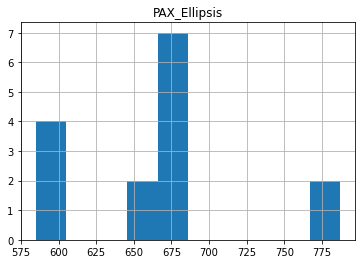

In [106]:
ellipsis.hist()

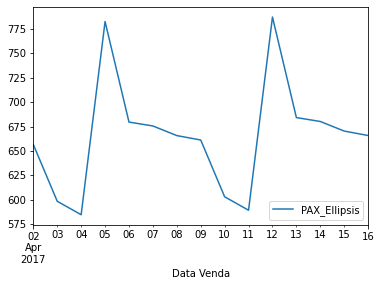

In [135]:
(ellipsis.set_index(['Data Venda'])).plot();

#### Todos conjuntos de dados apresentam grande variação

## Treinamento do modelo

In [ ]:
data_train = df_wine

#
# Separando dados e Classes
X = data_train.drop(['quality'], axis=1)
y_class = data_train['quality']

# Padronizando os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


X = X_scaled
y = y_class


In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
# Criando uma funcao para criação, execução e validação do modelo
def run_model():
       
    clf_KNN = KNeighborsClassifier(n_neighbors=5)
    clf_arvore = DecisionTreeClassifier()
    clf_floresta = RandomForestClassifier(max_depth=10, random_state=1)
    clf_svm=SVC(gamma='auto',kernel='rbf')
    clf_mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5, 5), random_state=1)


    modelos= [clf_KNN, clf_arvore, clf_floresta, clf_svm, clf_mlp]
    nome_modelos = ['clf_KNN', 'clf_arvore', 'clf_floresta', 'clf_svm', 'clf_mlp']

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # Fit do modelo
    for i in range(len(modelos)):
        print("Treinando modelo: ", nome_modelos[i])
        modelos[i].fit(x_train, y_train)
    print("\n")    
    # Predição no dataset de treino
    preds=[]
    for i in range(len(modelos)):
        print("Previsoes com o modelo: ", nome_modelos[i])
        preds.append(modelos[i].predict(x_test))
    print("\n") 

    # Exibir o relatorio do modelo
    for i in range(len(preds)):
        print("Modelo: ", nome_modelos[i],"--> Acurácia : %.4g" % accuracy_score(y_test, preds[i]))
        print("Modelo: ", nome_modelos[i],"--> Acurácia : %.4g\n" % modelos[i].score(x_test, y_test))


In [ ]:
run_model()

In [ ]:
# Importando o algoritmo MLP
from sklearn.neural_network import MLPClassifier

# Instanciando o algoritmo
clf_mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5, 5), random_state=1)

# Efetuando o treinamento do modelo
clf_mlp.fit(x_train, y_train)


print("Acurácia: {}".format(clf_mlp.score(x_test, y_test)))

In [ ]:
# Checar o ultimo resultado com clf_mlp
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5, 5), random_state=1)
clf_mlp.fit(x_train, y_train)
print("clf_mlp -->  Acurácia : %.4g\n" % clf_mlp.score(x_test, y_test))

### Alterada a classe quality para class: bom ou ruim

In [ ]:
df_wine2 = df_wine

In [ ]:
df_wine2.head()

In [ ]:
df_wine2['class'] = np.where(df_wine['quality'] <= 5, "ruim", "bom")

In [ ]:
df_wine2.head()

In [ ]:
df_wine2.drop('quality', axis=1, inplace=True)

data_train = df_wine2

#
# Separando dados e Classes
X = data_train.drop(['class'], axis=1)
y_class = data_train['class']

# Padronizando os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


X = X_scaled
y = y_class

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [ ]:
# Aplicar no randomforest
clf_floresta = RandomForestClassifier(max_depth=10, random_state=1)
# Treinamento
clf_floresta.fit(x_train, y_train)
# Previsao
pred = clf_floresta.predict(x_test)
# Acurácia
accuracy_score(y_test,pred)
print("clf_floresta -->  Acurácia : %.4g\n" % accuracy_score(y_test, pred))






## Eliminação Recursiva de Atributos

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

Esta é outra técnica para seleção de atributos, que recursivamente remove os atributos e constrói o modelo com os atributos remanescentes. Esta técnica utiliza a acurácia do modelo para identificar os atributos que mais contribuem para prever a variável alvo. Em inglês esta técnia é chamada Recursive Feature Elimination (RFE).

O exemplo abaixo utiliza a técnica de eliminação recursiva de atributos com um algoritmo de Regressão Logística para selecionar as 3 melhores variáveis preditoras. O RFE selecionou as variáveis preg, mass e pedi, que estão marcadas como True em "Atributos Selecionados" e com valor 1 em "Ranking dos Atributos".

In [ ]:
# Eliminação Recursiva de Variáveis

# Import dos módulos
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Carregando os dados
#arquivo = 'data/pima-data.csv'
#colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dados = read_csv(arquivo, names = colunas)
#array = dados.values

# Separando dados e Classes
X = data_train.drop(['ID','target'], axis=1)
y = data_train['target']

# Padronizando os dados
#scaler = StandardScaler()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_sample(X, y)

dados = data_train

# Separando o array em componentes de input e output
#X = array[:,0:8]
#Y = array[:,8]

# Criação do modelo
modelo = LogisticRegression()

# RFE
rfe = RFE(modelo, 5)
#fit = rfe.fit(X, Y)
fit = rfe.fit(X_train_sm, y_train_sm)

# Print dos resultados
print("Variáveis Preditoras:", dados.columns[2:50])
print("Variáveis Selecionadas: %s" % fit.support_)
print("Ranking dos Atributos: %s" % fit.ranking_)
print("Número de Melhores Atributos: %d" % fit.n_features_)

## Método Ensemble para Seleção de Variáveis

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

Bagged Decision Trees, como o algoritmo RandomForest (esses são chamados de Métodos Ensemble), podem ser usados para estimar a importância de cada atributo. Esse método retorna um score para cada atributo.

Quanto maior o score, maior a importância do atributo.

In [ ]:
# Importância do Atributo com o Extra Trees Classifier

# Import dos Módulos
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier

# Carregando os dados
#arquivo = 'data/pima-data.csv'
#colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dados = read_csv(arquivo, names = colunas)
#array = dados.values

# Separando o array em componentes de input e output
#X = array[:,0:8]
#Y = array[:,8]

# Criação do Modelo - Feature Selection
modelo = ExtraTreesClassifier()
modelo.fit(X_train_sm, y_train_sm)
importances = modelo.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelo.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

#modelo.fit(X, Y)
#modelo.fit(X_train_sm, y_train_sm)

# Print dos Resultados
#print(dados.columns[2:20])
#print(modelo.feature_importances_)

## Redução de Dimensionalidade (Feature Extraction)

## Principal Component Analysis (PCA)

O PCA foi inventado em 1901 por Karl Pearson e utiliza álgebra linear para transformar datasets em uma forma comprimida, o que é geralmente conhecido como Redução de Dimensionalidade. Com PCA você pode escolher o número de dimensões (chamados componentes principais) no resultado transformado. Vamos usar PCA para selecionar 3 componentes principais.

A Análise de Componentes Principais (PCA) é um método para extração das variáveis importantes (na forma de componentes) a partir de um grande conjunto de variáveis, disponíveis em um conjunto de dados. Esta técnica permite extrair um número pequenos de conjuntos dimensionais a partir de um dataset altamente dimensional. Com menos variáveis a visualização também se torna muito mais significativa. PCA é mais útil quando se lida com 3 ou mais dimensões.

In [ ]:
# Image source: http://www.nlpca.org/pca_principal_component_analysis.html
from IPython.display import Image
Image(url = 'images/PCA2.png')

Cada componente resultante é uma combinação linear de n atributos. Ou seja, cada componente principal é uma combinação de atributos presentes no dataset. O Primeiro Componente Principal é a combinação linear dos atributos com máxima variância e determina a direção em que há mais alta variabilidade nos dados. Quanto maior a variabilidade capturada no primeiro componente principal, mais informação será capturada pelo componente. O Segundo Componente Principal captura a variabilidade remanescente. Todos os componentes subsequentes possuem o mesmo conceito.

In [ ]:
# Image source: http://www.nlpca.org/pca_principal_component_analysis.html
from IPython.display import Image
Image(url = 'images/PCA3.png')

O PCA precisa ser alimentado com dados normalizados. Utilizar o PCA em dados não normalizados pode gerar resultados inesperados.

A análise de componentes principais é uma técnica da estatística multivariada que consiste em transformar um conjunto de variáveis originais em outro conjunto de variáveis denominadas de componentes principais. Os componentes principais apresentam propriedades importantes: cada componente principal é uma combinação linear de todas as variáveis originais, são independentes entre si e estimados com o propósito de reter, em ordem de estimação, o máximo de informação, em termos da variação total contida nos dados. Os componentes principais são garantidamente independentes apenas se os dados forem normalmente distribuídos (conjuntamente).

Procura-se redistribuir a variação observada nos eixos originais de forma a se obter um conjunto de eixos ortogonais não correlacionados. Esta técnica pode ser utilizada para geração de índices e agrupamento de indivíduos. A análise agrupa os indivíduos de acordo com sua variação, isto é, os indivíduos são agrupados segundo suas variâncias, ou seja, segundo seu comportamento dentro da população, representado pela variação do conjunto de características que define o indivíduo, ou seja, a técnica agrupa os indivíduos de uma população segundo a variação de suas características.

A análise de componentes principais é associada à idéia de redução de massa de dados, com menor perda possível da informação. 

O objetivo é sumarizar os dados que contém muitas variáveis (p) por um conjunto menor de variáveis (k) compostas derivadas a partir do conjunto original. PCA usa uma conjunto de dados representado por uma matriz de n registros por p atributos, que podem estar correlacionados, e sumariza esse conjunto por eixos não correlacionados (componentes principais) que são uma combinação linear das p variáveis originais. As primeiras k componentes contém a maior quantidade de variação dos dados.

Em termos gerais a PCA busca reduzir o número de dimensões de um dataset, projetando os dados em um novo plano. Usando essa nova projeção os dados originais, que podem envolver diversas variáveis, podem ser interpretados utilizando menos "dimensões."

No dataset reduzido podemos observar com mais clareza tendências, padrões e/ou outliers. Mas vale lembrar que a regra: "Se não está nos dados brutos não existe!" é sempre válida. A PCA fornece apenas mais clareza aos padrões que já estão lá.

In [ ]:
from IPython.display import Image
Image(url = 'images/PCA.png')

Quanto maior a variância, maior a quantidade de informação contida no componente.

In [ ]:
# Feature Extraction

# Import dos módulos
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Normalizando os dados
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(X)

# Seleção de atributos
pca = PCA(n_components = 4)
fit = pca.fit(rescaledX)

# Sumarizando os componentes
print("Variância: %s" % fit.explained_variance_ratio_)
print(fit.components_)

## Amostragem - Resampling

Você precisa saber se seu modelo preditivo vai funcionar bem quando receber novos dados. A melhor maneira de avaliar a performance do modelo é fazer previsões em dados que você já conhece o resultado. Outra maneira de testar a performance do seu modelo é utilizar técnicas estatísticas como métodos de amostragem que permitem você estimar quão bem seu modelo irá fazer previsões em novos dados.

A avaliação do modelo é uma estimativa de quão bem o algoritmo será capaz de prever em novos dados. Isso não garante performance. Após avaliar o modelo, nós podemos treiná-lo novamente com os dados de treino e então prepará-lo para uso operacional em produção. Existem diversas técnicas para isso e estudaremos duas aqui: Conjunto de dados de treino e de teste e Cross Validation.

### Dados de Treino e de Teste

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Este é o método mais utilizado para avaliar performance de um algoritmo de Machine Learning. Dividimos nossos dados originais em dados de treino e de teste. Treinamos o algoritmo nos dados de treino e fazemos as previsões nos dados de teste e avaliamos o resultado. A divisão dos dados vai depender do seu dataset, mas utiliza-se com frequência tamanhos entre 70/30 (treino/teste) e 65/35 (treino/teste).

Este método é bem veloz e ideal para conjuntos de dados muito grandes. O ponto negativo é a possibilidade de alta variância.

In [ ]:
# Avaliação usando dados de treino e de teste

# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo o tamanho das amostras
teste_size = 0.33

# Garante que os resultados podem ser reproduzidos
# Isso é importante para comparar a acurácia com outros algoritmos de Machine Learning.
seed = 7

# Criando os conjuntos de dados de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criação do modelo
modelo = LogisticRegression()

# Treinamento do modelo
modelo.fit(X_treino, Y_treino)

# Score do modelo nos dados de teste
result = modelo.score(X_teste, Y_teste)
print("Acurácia nos Dados de Teste: %.3f%%" % (result * 100.0))

### Cross Validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

Cross Validation é uma técnica que pode ser utilizada para avaliar a performance de um modelo com menos variância que a técnica de dividir os dados em treino/teste. Com esta técnica dividimos os dados em partes normalmente chamadas de k-folds (por exemplo k = 5, k = 10). Cada parte é chamada fold. O algoritmo é treinado em k-1 folds. Cada fold é usado no treinamento de forma repetida e um fold por vez. Após executar o processo em k-1 folds, podemos sumarizar a performance em cada fold usando a média e o desvio padrão (Eu disse que Estatística era importante no processo de Big Data Analytics). O resultado é normalmente mais confiável e oferece maior acurácia ao modelo. A chave deste processo está em definir o correto valor de k, de modo que o número de folds represente adequadamente o número de repetições necessárias.

In [ ]:
from IPython.display import Image
Image(url = 'images/cross-validation.jpg')

In [ ]:
# Avaliação usando Cross Validation

# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = LogisticRegression()
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Usamos a média e o desvio padrão
print("Acurácia Final: %.3f%%" % (resultado.mean() * 100.0))

## Avaliando a Performance

As métricas que você escolhe para avaliar a performance do modelo vão influenciar a forma como a performance é medida e comparada com modelos criados com outros algoritmos.

Vamos utilizar o mesmo algoritmo, mas com métricas diferentes e assim comparar os resultados. A função cross_validation.cross_val_score() será usada para avaliar a performance.

### Métricas para Algoritmos de Classificação

https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
# Acurácia
# Número de previsões corretas. É útil apenas quando existe o mesmo número de observações em cada classe.

# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = LogisticRegression()

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')

# Print dos resultados
print("Acurácia: %.3f" % (resultado.mean() * 100))

In [ ]:
# Curva ROC 
# A Curva ROC permite analisar a métrica AUC (Area Under the Curve).
# Essa é uma métrica de performance para classificação binária, em que podemos definir as classes em positiavs e negativas.
# Problemas de classificação binária são um trade-off sentre Sensitivity e Specifity.
# Sensitivity é a taxa de verdadeiros positivos (TP). Ese é o número de instâncias positivas da primeira classe que foram previstas corretamente.
# Specifity é a taxa de verdadeiros negativos (TN). Esse é o número de instâncias da segunda classe que foram previstas corretamente.
# Valores acima de 0.5 indicam uma boa taxa de previsão.

# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
model = LogisticRegression()

# Cross Validation
resultado = cross_val_score(model, X, Y, cv = kfold, scoring = 'roc_auc')

# Print do resultado
print("AUC: %.3f" % (resultado.mean() * 100))

In [ ]:
# Confusion Matrix
# Permite verificar a acurácia em um formato de tabela

# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criando o modelo
model = LogisticRegression()
model.fit(X_treino, Y_treino)

# Fazendo as previsões e construindo a Confusion Matrix
previsoes = model.predict(X_teste)
matrix = confusion_matrix(Y_teste, previsoes)

# Imprimindo a Confusion Matrix
print(matrix)

In [ ]:
# Relatório de Classificação

# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criando o modelo
modelo = LogisticRegression()
modelo.fit(X_treino, Y_treino)

# Fazendo as previsões e construindo o relatório
previsoes = model.predict(X_teste)
report = classification_report(Y_teste, previsoes)

# Imprimindo o relatório
print(report)

# Algoritmos de Classificação

Não temos como saber qual algoritmo vai funcionar melhor na construção do modelo, antes de testarmos o algoritmo com nosso dataset. O ideal é testar alguns algoritmos e então escolher o que fornece melhor nível de precisão. Vamos testar um conjunto de algoritmos de classificação, nas mesmas condições.

## Regressão Logística

Algoritmo Linear. O algoritmo de Regressão Logística assume que seus dados estão em uma Distribuição Normal para valores numéricos que podem ser modelados com classificação binária.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = LogisticRegression()

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

## Linear Discriminant Analysis

Algoritmo Linear. Técnica estatística para classificação binária. Também assume que os dados estão em Distribuição Normal.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = LinearDiscriminantAnalysis()

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

## KNN - K-Nearest Neighbors

Algoritmo Não-Linear que utiliza uma métrica de distância para encontrar o valor de K mais adequado as instâncias do dataset de treino.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
random_state = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = random_state)

# Criando o modelo
modelo = KNeighborsClassifier()

# Cross Validation
results = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

## Naive Bayes

Algoritmo Não-Linear. Calcula a Probabilidade de cada classe e a probabilidade condicional de cada classe dado uma variável de entrada. As probabilidades são então estimadas para os novos dados e multiplicadas, assumindo que são independentes (suposição simples ou Naive). Assume dados em distirbuição Gaussiana (Normal)

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = GaussianNB()

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

## CART (Classification and Regression Trees)

Algoritmo Não-Linear. O algoritmo CART constrói uma árvore binária a partir do dataset de treino. Cada atributo e cada valor de cada atributo são avaliados com o objetivo de reduzir a função de custo (Cost Function).

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = DecisionTreeClassifier()

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

## SVM - Support Vector Machines

O objetivo deste algoritmo é buscar uma linha que melhor separa duas classes dentro de um conjunto de dados. As instâncias de dados que estão mais próximas desta linha que separa as classes, são chamadas support vectors. O SVM tem sido estendido para suportar multiclasses.

Support Vector Machines são algoritmos de classificação muito poderosos. Quando usados em conjunto com “Random forest” e outras ferramentas de aprendizagem de máquina, dão uma dimensão muito diferente para montagem de modelos. Assim, eles se tornam cruciais para os casos em que é necessária um poder de previsão muito elevado. Esses algoritmos são um pouco mais difíceis de visualizar devido à complexidade na formulação.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = SVC()

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

# Seleção do Modelo Preditivo

Veremos que os algoritmos de Regressão Logística e Linear Discriminant Analysis apresentaram o melhor nível de precisão.

In [ ]:
# Import dos módulos
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Preparando a lista de modelos
modelos = []
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('SVM', SVC()))

# Avaliando cada modelo em um loop
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

## Otimização do Modelo - Ajuste de Hyperparâmetros

Todos os algoritmos de Machine Learning são parametrizados, o que significa que você pode ajustar a performance do seu modelo preditivo, através do tuning (ajuste fino) dos parâmetros. Seu trabalho é encontrar a melhor combinação entre os parâmetros em cada algoritmo de Machine Learning. Esse processo também é chamado de Otimização de Hyperparâmetros. O scikit-learn oferece dois métodos para otimização automática dos parâmetros: Grid Search Parameter Tuning e Random Search Parameter Tuning. 

### Grid Search Parameter Tuning

Este método realiza metodicamente combinações entre todos os parâmetros do algoritmo, criando um grid. Vamos experimentar este método utilizando o algoritmo de Regressão Logística. 

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores que serão testados
valores_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

# Criando o modelo
modelo = LogisticRegression()

# Criando o grid
grid = GridSearchCV(estimator = modelo, param_grid = valores_grid)
grid.fit(X, Y)

# Print do resultado
print("Acurácia: %.3f" % (grid.best_score_ * 100))
print("Melhores Parâmetros do Modelo:\n", grid.best_estimator_)

### Random Search Parameter Tuning

Este método gera amostras dos parâmetros dos algoritmos a partir de uma distribuição randômica uniforme para um número fixo de iterações. Um modelo é construído e testado para cada combinação de parâmetros.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores que serão testados
seed = 7
iterations = 14

# Definindo os valores que serão testados
valores_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

# Criando o modelo
modelo = LogisticRegression()

# Criando o grid
rsearch = RandomizedSearchCV(estimator = modelo, 
                             param_distributions = valores_grid, 
                             n_iter = iterations, 
                             random_state = seed)
rsearch.fit(X, Y)

# Print dos resultados
print("Acurácia: %.3f" % (rsearch.best_score_ * 100))
print("Melhores Parâmetros do Modelo:\n", rsearch.best_estimator_)

# Salvando o resultado do seu trabalho

In [ ]:
# Salvando o resultado do seu trabalho
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo o tamanho dos dados de treino e de teste
teste_size = 0.33
seed = 7

# Criando o dataset de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criando o modelo
modelo = LogisticRegression()

# Treinando o modelo
modelo.fit(X_treino, Y_treino)

# Salvando o modelo
arquivo = 'modelos/modelo_classificador_final.sav'
pickle.dump(modelo, open(arquivo, 'wb'))
print("Modelo salvo!")

# Carregando o arquivo
modelo_classificador_final = pickle.load(open(arquivo, 'rb'))
modelo_prod = modelo_classificador_final.score(X_teste, Y_teste)
print("Modelo carregado!")

# Print do resultado
print("Acurácia: %.3f" % (modelo_prod.mean() * 100))

# Otimizando Performance com Métodos Ensemble

Métodos Ensemble permitem aumentar consideravelmente o nível de precisão nas suas previsões. Veremos como criar alguns dos Métodos Ensemble mais poderosos em Python. Existem 3 métodos principais para combinar previsões a partir de diferentes modelos:

Bagging - Para construção de múltiplos modelos (normalmente do mesmo tipo) a partir de diferentes subsets no dataset de treino.

Boosting - Para construção de múltiplos modelos (normalmente do mesmo tipo), onde cada modelo aprende a corrigir os erros gerados pelo modelo anterior, dentro da sequência de modelos criados.

Voting - Para construção de múltiplos modelos (normalmente de tipos diferentes) e estatísticas simples (como a média) são usadas para combinar as previsões.

Vejamos como utilizar estes métodos.

### Bagged Decision Trees

Este método funciona bem quando existe alta variância nos dados

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Cria o modelo unitário (classificador fraco)
cart = DecisionTreeClassifier()

# Definindo o número de trees
num_trees = 100

# Criando o modelo bagging
modelo = BaggingClassifier(base_estimator = cart, n_estimators = num_trees, random_state = seed)

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

### Random Forest

Random Forest é uma extensão do Baggig Decision Tree. Amostras do dataset de treino são usadas com reposição, mas as árvores são criadas de uma forma que reduz a correlação entre classificadores individuais (Random Forest é um conjunto de árvores de decisão).

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Definindo o número de trees
num_trees = 100
max_features = 3

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = RandomForestClassifier(n_estimators = num_trees, max_features = max_features)

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

### AdaBoost

Algoritmos baseados em Boosting Ensemble criam uma sequência de modelos que tentam corrigir os erros dos modelos anteriores dentro da sequência. Uma vez criados, os modelos fazem previsões que podem receber um peso de acordo com sua acurácia e os resultados são combinados para criar uma previsão única final. 

O AdaBoost atribui pesos às instâncias no dataset, definindo quão fácil ou difícil elas são para o processo de classificação, permitindo que o algoritmo tenha mais ou menos atenção às instâncias durante o processo de construção dos modelos.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Definindo o número de trees
num_trees = 30

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = AdaBoostClassifier(n_estimators = num_trees, random_state = seed)

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

### Gradient Boosting

Também chamado Stochastic Gradient Boosting, é um dos métodos Ensemble mais sofisticados.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Definindo o número de trees
num_trees = 100

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo = GradientBoostingClassifier(n_estimators = num_trees, random_state = seed)

# Cross Validation
resultado = cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

### Voting Ensemble

Este é um dos métodos Ensemble mais simples. Este método cria dois ou mais modelos separados a partir do dataset de treino. O Classificador Voting então utiliza a média das previsões de cada sub-modelo para fazer as previsões em novos conjuntos de dados. As previsões de cada sub-modelo podem receber pesos, através de parâmetros definidos manualmente ou através de heurística. Existem versões mais avançadas do Voting, em que o modelo pode aprender o melhor peso a ser atribuído aos sub-modelos. Isso é chamado Stacked Aggregation, mas ainda não está disponível no Scikit-learn.

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo os valores para o número de folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando os modelos
estimators = []

modelo1 = LogisticRegression()
estimators.append(('logistic', modelo1))

modelo2 = DecisionTreeClassifier()
estimators.append(('cart', modelo2))

modelo3 = SVC()
estimators.append(('svm', modelo3))

# Criando o modelo ensemble
ensemble = VotingClassifier(estimators)

# Cross Validation
resultado = cross_val_score(ensemble, X, Y, cv = kfold)

# Resultado
print("Acurácia: %.3f" % (resultado.mean() * 100))

## Algoritmo XGBoost - Extreme Gradient Boosting

O algoritmo XGBoost é uma extensão do GBM (Gradient Boosting Method) que permite trabalhar com multithreading em uma única máquina e processamento paralelo em um cluster de vários servidores. A principal vantagem do XGBoost sobre o GBM é sua capacidade de gerenciar dados esparsos. O XGBoost automaticamente aceita dados esparsos como input sem armazenar zeros na memória.

Principais vantagensdo XGBoost:

1- Aceita dados esparsos (o que permite trabalhar com matrizes esparsas), sem a necessidade de conversão para matrizes densas.

2- Constrói uma árvore de aprendizagem utilizando um moderno método de split (chamado quatile sketch), o que resulta em tempo de processamento muito menor que métodos tradicionais.

3- Permite computação paralela em uma única máquina (através do uso de multithreading) e processamento paralelo em máquinas distribuídas em cluster.

Basicamente o XGBoost utiliza os mesmos parâmetros do GBM e permite tratamento avançado de dados missing.

O XGBoost é muito utilizado por Cientistas de Dados que vencem competições no Kaggle. Repositório no Github: https://github.com/dmlc/XGBoost

### Instalar XGBoost a partir do PyPi
!pip install xgboost

In [ ]:
!pip install xgboost

In [ ]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Definindo o tamanho dos dados de treino e de teste
teste_size = 0.33
seed = 7

# Criando o dataset de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criando o modelo
modelo = XGBClassifier()

# Treinando o modelo
modelo.fit(X_treino, y_treino)

# Pront do modelo
print(modelo)

# Fazendo previsões
y_pred = modelo.predict(X_teste)
previsoes = [round(value) for value in y_pred]

# Avaliando as previsões
accuracy = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

# Fim

### Obrigado - Data Science Academy - <a href="http://facebook.com/dsacademybr">facebook.com/dsacademybr</a>

In [ ]:
# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1, n_estimators = 400)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)